<a href="https://colab.research.google.com/github/kunwarAbhay/NLP/blob/main/Word2Vec/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

In [129]:
import torch
import torch.nn as nn
import numpy as np
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import Dataset, DataLoader

In [143]:
corpus = ["apple banana fruit", "banana orange fruit", "orange banana fruit", "dog cat animal", "cat monkey animal", "monkey dog animal"]

vocabulary = list(set(" ".join(corpus).split(" "))) # Set of unique words in corpus
word_dict = {word : pos for pos, word in enumerate(vocabulary)}

print("Vocabulary: ", vocabulary)
print("Word Dictionary: ", word_dict)

Vocabulary:  ['fruit', 'animal', 'apple', 'cat', 'monkey', 'orange', 'dog', 'banana']
Word Dictionary:  {'fruit': 0, 'animal': 1, 'apple': 2, 'cat': 3, 'monkey': 4, 'orange': 5, 'dog': 6, 'banana': 7}


In [144]:
window_size = 1
skip_grams = []

for sentence in corpus:
  sentence = sentence.split(" ")
  for i in range(len(sentence)):
    context_start = min(i - window_size, 0)
    context_end = min(i + window_size, len(sentence) - 1)
    for j in range(context_start, context_end):
      if i != j:
        skip_grams.append([word_dict[sentence[i]], word_dict[sentence[j]]])

print("Skip Grams: ", skip_grams)

Skip Grams:  [[2, 0], [7, 2], [0, 2], [0, 7], [7, 0], [5, 7], [0, 7], [0, 5], [5, 0], [7, 5], [0, 5], [0, 7], [6, 1], [3, 6], [1, 6], [1, 3], [3, 1], [4, 3], [1, 3], [1, 4], [4, 1], [6, 4], [1, 4], [1, 6]]


In [145]:
BATCH_SIZE = 4
EMBEDDING_SIZE = 2
VOCAB_SIZE = len(word_dict)

In [146]:
class Word2Vec(nn.Module):
  def __init__(self, vocab_size, embedding_size):
    super().__init__()
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size

    self.layers = nn.Sequential(
        nn.Linear(vocab_size, embedding_size, bias=False), # hidden layer
        nn.Linear(embedding_size, vocab_size, bias=False), # output layer
    )

  def forward(self, x):
    return self.layers(x)

In [147]:
model = Word2Vec(vocab_size=VOCAB_SIZE, embedding_size=EMBEDDING_SIZE)

loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=VOCAB_SIZE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [148]:
class WordDataset(Dataset):
  def __init__(self, data, vocab_size):
    super().__init__()
    self.data = data
    self.vocab_size =  vocab_size
    self.size = len(data)

  def __len__(self):
    return self.size

  def __getitem__(self, index):
    target = torch.zeros(size=(self.vocab_size,))
    target[self.data[index][0]] = 1

    context = self.data[index][1]

    return target, context

In [149]:
dataset = WordDataset(skip_grams, vocab_size=VOCAB_SIZE)

In [150]:
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [151]:
torch.manual_seed(42)

epochs = 1000

# Build training and evaluation loop
for epoch in range(epochs):

  train_loss, test_loss = 0, 0
  train_acc, test_acc = 0, 0

  for X, y in loader:
    ## TRAINING
    model.train()

    # 1. Forward Pass
    y_logits = model(X)
    y_pred = torch.softmax(y_logits, dim=1)

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y)
    acc = acc_fn(y_pred, y)

    train_loss += loss
    train_acc += acc

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ## TESTING
    model.eval()
    with torch.inference_mode():
      test_logits = model(X)
      test_pred = torch.softmax(test_logits, dim=1)

      test_loss += loss_fn(test_logits, y)
      test_acc += acc_fn(test_pred, y)

  train_loss = train_loss / len(loader)
  train_acc = train_acc / len(loader)
  test_loss = test_loss / len(loader)
  test_acc = test_acc / len(loader)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 2.13 | Accuracy: 0.00 | Test Loss: 2.09 | Test Accuracy: 0.09
Epoch: 100 | Loss: 1.37 | Accuracy: 0.25 | Test Loss: 1.15 | Test Accuracy: 0.38
Epoch: 200 | Loss: 1.29 | Accuracy: 0.14 | Test Loss: 1.12 | Test Accuracy: 0.36
Epoch: 300 | Loss: 1.21 | Accuracy: 0.20 | Test Loss: 1.11 | Test Accuracy: 0.30
Epoch: 400 | Loss: 1.22 | Accuracy: 0.17 | Test Loss: 1.10 | Test Accuracy: 0.28
Epoch: 500 | Loss: 1.07 | Accuracy: 0.40 | Test Loss: 1.09 | Test Accuracy: 0.30
Epoch: 600 | Loss: 1.55 | Accuracy: 0.00 | Test Loss: 1.08 | Test Accuracy: 0.38
Epoch: 700 | Loss: 1.36 | Accuracy: 0.14 | Test Loss: 1.08 | Test Accuracy: 0.40
Epoch: 800 | Loss: 1.00 | Accuracy: 0.50 | Test Loss: 1.07 | Test Accuracy: 0.34
Epoch: 900 | Loss: 1.17 | Accuracy: 0.17 | Test Loss: 1.07 | Test Accuracy: 0.31


In [152]:
# Extract the hidden layer learned parameters
hidden_layer = next(model.parameters()).detach().numpy()

lookup_table = []

for word in word_dict:
  index = word_dict[word]
  lookup_table.append([hidden_layer[0][index], hidden_layer[1][index]])

print("Lookup Table:")
print(lookup_table)

Lookup Table:
[[1.5623918, 2.882977], [-2.7095935, 1.6490853], [4.050278, -3.2552803], [-0.8362339, -0.7043693], [-4.8082514, -2.3000093], [10.434062, 0.38669512], [-0.80116475, -0.699904], [1.0853459, -0.045778923]]


In [153]:
lookup_table = np.array(lookup_table)

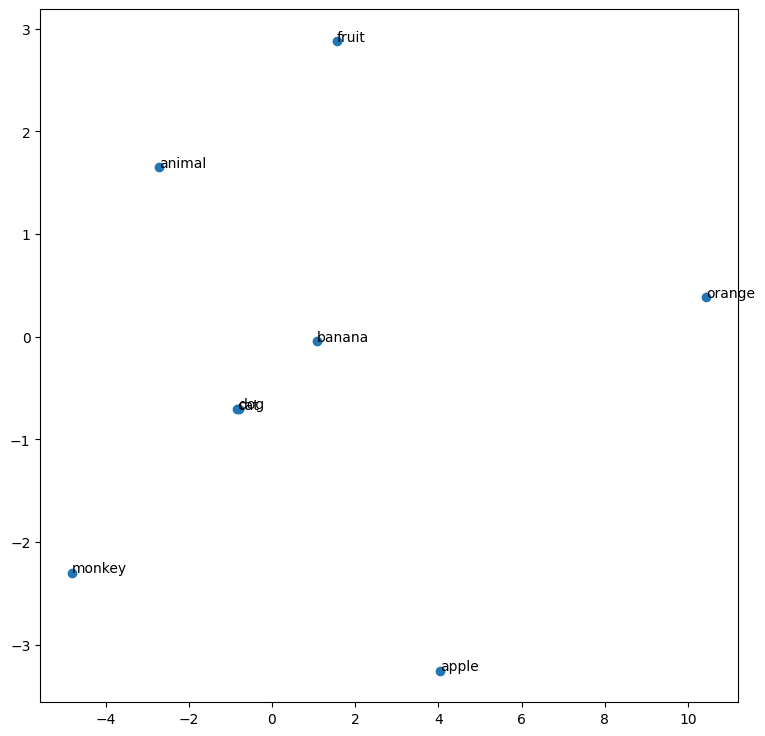

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))
plt.scatter(lookup_table[:, 0], lookup_table[:, 1])

for i in range(len(lookup_table)):
  plt.text(lookup_table[i][0], lookup_table[i][1], vocabulary[i])

# Reference


*   [word2vec-tutorial-the-skip-gram-model](https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
*   [illustrated-word2vec](https://jalammar.github.io/illustrated-word2vec/)
*   [graykode/nlp-tutorial](https://github.com/graykode/nlp-tutorial/)


